In [1]:
import sys
sys.path.append("../examples")
from full_adder import FullAdder

In [2]:
from magma import *
from magma.primitives import DefineRegister

N = 4
Register4 = DefineRegister(4, has_ce=True)
T = Bits(N)

class EnableShiftRegister(Circuit):
    name = "EnableShiftRegister"
    IO = ["I", In(T), "shift", In(Bit), "O", Out(T), "CLK", In(Bit)]
    @classmethod
    def definition(io):
        regs = [Register4().when(io.shift) for _ in range(N)]
        [wire(io.CLK, reg.clk) for reg in regs]  # TODO: Clean up this clock wiring
        wire(io.I, regs[0].D)
        fold(regs, foldargs={"D":"Q"})
        wire(regs[-1].Q, io.O)

In [3]:
from magma.backend.verilog import compile as compile_verilog
print(compile_verilog(EnableShiftRegister))

compiling EnableShiftRegister
module EnableShiftRegister (input [3:0] I, input  shift, output [3:0] O, input  CLK);
wire [3:0] inst0_Q;
wire [3:0] inst1_Q;
wire [3:0] inst2_Q;
wire [3:0] inst3_Q;
Reg_PE #(.WIDTH(4)) inst0 (.D(I), .clk(CLK), .Q(inst0_Q), .en(shift));
Reg_PE #(.WIDTH(4)) inst1 (.D(inst0_Q), .clk(CLK), .Q(inst1_Q), .en(shift));
Reg_PE #(.WIDTH(4)) inst2 (.D(inst1_Q), .clk(CLK), .Q(inst2_Q), .en(shift));
Reg_PE #(.WIDTH(4)) inst3 (.D(inst2_Q), .clk(CLK), .Q(inst3_Q), .en(shift));
assign O = inst3_Q;
endmodule




In [4]:
from magma.python_simulator import PythonSimulator
from magma.scope import Scope
from magma.bit_vector import BitVector

simulator = PythonSimulator(EnableShiftRegister)
scope = Scope()
O0 = []
O1 = []
O2 = []
O3 = []
for i in range(1 << N):
    simulator.set_value(EnableShiftRegister.I, scope, [bool(x) for x in int2seq(i, N)])
    simulator.set_value(EnableShiftRegister.shift, scope, bool(i % 2))
    for j in range(2):
        simulator.step()
        simulator.evaluate()
        O = simulator.get_value(EnableShiftRegister.O, scope)
        O0.append(O[0])
        O1.append(O[1])
        O2.append(O[2])
        O3.append(O[3])

print([seq2int(val) for val in zip(O0, O1, O2, O3)])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 3, 3, 3, 3, 5, 5, 5, 5, 7, 7, 7, 7, 9, 9]


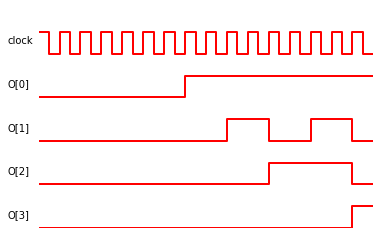

In [5]:
import matplotlib.pyplot as plt
import numpy as np

n = len(O1)//2
t = np.repeat(0.5*np.arange(2*n+1),2)[1:-1]
clock = np.tile(np.array([1,1,0,0]),n)

O0 = np.repeat(np.array(O0),2)
O1 = np.repeat(np.array(O1),2)
O2 = np.repeat(np.array(O2),2)
O3 = np.repeat(np.array(O3),2)

plt.text(-1.5, 4.25, 'clock')
plt.plot(t, 0.5*clock+4, 'r', linewidth = 2)
plt.text(-1.5, 3.25, 'O[0]')
plt.plot(t, 0.5*O0+3,    'r', linewidth = 2)
plt.text(-1.5, 2.25, 'O[1]')
plt.plot(t, 0.5*O1+2,    'r', linewidth = 2)
plt.text(-1.5, 1.25, 'O[2]')
plt.plot(t, 0.5*O2+1,    'r', linewidth = 2)
plt.text(-1.5, 0.25, 'O[3]')
plt.plot(t, 0.5*O3,    'r', linewidth = 2)
plt.xlim([0,n])
plt.ylim([0,5])

plt.gca().axis('off')
plt.show()